In [36]:
import os
import re
from collections import defaultdict
import jsonlines
import matplotlib.pyplot as plt
import numpy as np

def parse_data_to_dictionary(folder_path = "experiment_data"):
    # Corrected pattern to match filenames and extract information
    filename_pattern = re.compile(
        r"(?P<transmitter>\w+)_"
        r"(?P<blocker>\w+)_"
        r"(?P<tx_power>-?\d+)dBm(?P<block_power>-?\d+)dBm_"
        r"(?P<tx_freq>\d+)MHz(?P<block_freq>\d+)MHz"
    )

    # Dictionary to store grouped data by transmitter_blocker
    grouped_files = defaultdict(list)

    # Parse filenames in the folder
    for filename in os.listdir(folder_path):
        match = filename_pattern.match(filename)
        if match:
            data = match.groupdict()
            # Extract and convert data
            data["tx_power"] = int(data["tx_power"])
            data["block_power"] = int(data["block_power"])
            data["tx_freq"] = int(data["tx_freq"])
            data["block_freq"] = int(data["block_freq"])
            data["frequency_offset"] = data["block_freq"] - data["tx_freq"]
            data["filename"] = filename

            # Group by transmitter_blocker
            transmitter_blocker = f"{data['transmitter']}_{data['blocker']}"
            grouped_files[transmitter_blocker].append(data)

    # Sort each group first by frequency offset, then by blocker power
    for transmitter_blocker, files in grouped_files.items():
        # First sort by frequency offset
        files.sort(key=lambda x: x["frequency_offset"])
        # Then within each frequency offset, sort by blocker power
        files.sort(key=lambda x: (x["frequency_offset"], x["block_power"]))

    return grouped_files

# files_dict = parse_data_to_dictionary("experiment_data")

# # Print the grouped and sorted data for validation
# for transmitter_blocker_group, files in files_dict.items():
#     print(f"Group: {transmitter_blocker_group}, length: {len(files)}")
#     for file in files:
#         print(file)
#     print("\n")

# del file, files, transmitter_blocker_group

# ----------------------------------------------------------------------------
def load_reference_message(transmitter_filename, reference_folder = "reference_messages"):
    # Construct the full path to the reference message file
    file_path = os.path.join(reference_folder, transmitter_filename)

    with jsonlines.open(file_path) as reader:
        reference_message = reader.read()["message"]
    
    return reference_message
    

def count_bit_errors_one_message(reference_message, message_bytes):
    # Initialize error counts
    bit_error_counts = [0] * (len(reference_message) * 8)  # For each bit in the message

    # Ensure messages are of equal length for comparison
    if len(reference_message) != len(message_bytes):
        raise ValueError("Message lengths do not match!")
    
    # Calculate bit errors by comparing each byte of the reference message and received message
    for byte_index, (ref_byte, msg_byte) in enumerate(zip(reference_message, message_bytes)):
        # Perform XOR operation between the reference byte and the message byte
        error_bits = ref_byte ^ msg_byte

        # Count bit errors by checking each bit position in the error_bits
        for bit_index in range(8):  # There are 8 bits in a byte
            if error_bits & (1 << bit_index): # 1 << 3 = 0x00001000 
                # Increment error count for the specific bit position
                bit_error_counts[byte_index * 8 + bit_index] += 1

    # Return the total number of bit errors
    total_bit_errors = sum(bit_error_counts)
    return total_bit_errors, bit_error_counts

def read_and_calculate_bit_errors(file_path, reference_message):
    # Initialize total bit errors and cumulative bit error counts
    total_bit_errors = 0
    cumulative_bit_error_distribution = [0] * (len(reference_message) * 8)  # Initialize cumulative counts for all bit positions
    total_packets = 0
    with jsonlines.open(file_path) as reader:
        for line in reader:
            message_bytes = line["message"]
            
            # Calculate bit errors with respect to the reference message

            if len(reference_message) != len(message_bytes):
                continue
            packet_bit_errors, bit_error_counts = count_bit_errors_one_message(reference_message, message_bytes)

            # Add to the total bit errors and accumulate the bit error counts
            total_bit_errors += packet_bit_errors
            for i in range(len(cumulative_bit_error_distribution)):
                cumulative_bit_error_distribution[i] += bit_error_counts[i]

            # Add to the total packets counter
            total_packets += 1
            
    return total_bit_errors, cumulative_bit_error_distribution, total_packets



# # Example usage:
# transmitter_filename = "BLE1MBit.jsonl"  # Replace with your actual transmitter file name

# # Load reference message from the corresponding transmitter file
# reference_message = load_reference_message(transmitter_filename)

# # Example: Read and calculate errors from a JSONL file
# file_path = "experiment_data/BLE1MBit_IEEE802154250Kbit_0dBm-4dBm_2425MHz2423MHz_delay255us_tx120B_block8B.jsonl"
# total_bit_errors, cumulative_bit_error_counts, total_packets = read_and_calculate_bit_errors(file_path, reference_message)

# # Output the result
# print(f"Total bit errors: {total_bit_errors}")
# print(f"Cumulative bit error counts for bit position: {cumulative_bit_error_counts}")
# print(f"Total packets: {total_packets}")



# ----------------------------------------------------------------------------
def add_bit_errors_to_files_dict(files_dict, folder="experiment_data"):
    # Process each group and file
    for transmitter_blocker_group, files in files_dict.items():
        for file in files:
            # Extract file details
            filename = file["filename"]
            transmitter = file["transmitter"]

            # Load reference message from the transmitter file
            reference_message = load_reference_message(f"{transmitter}.jsonl")

            # Calculate bit error metrics
            total_bit_errors, bit_error_distribution_cumulative, total_packets = read_and_calculate_bit_errors(
                os.path.join(folder, filename), reference_message
            )

            # Message length in bits (length of reference message * 8)
            length_id_bits = 4 * 8
            message_length_bits = len(reference_message) * 8 
            payload_length_bits = length_id_bits + message_length_bits

            # Blocking segments measured from digital analyser
            if transmitter == "BLE1MBit" and file["blocker"] == "IEEE802154250Kbit":
                blocked_bits = 80.65625 * 8
            elif transmitter == "BLE1MBit" and file["blocker"] == "tone":
                blocked_bits = 80.59375 * 8
            elif transmitter == "BLE1MBit" and file["blocker"] == "BLE1MBit":
                blocked_bits = 79.82025 * 8
            elif transmitter == "IEEE802154250Kbit" and file["blocker"] == "BLE1MBit":
                blocked_bits = 33.9550625 * 8
            elif transmitter == "IEEE802154250Kbit" and file["blocker"] == "tone":
                blocked_bits = 33.994125 * 8
            elif transmitter == "IEEE802154250Kbit" and file["blocker"] == "IEEE802154250Kbit":
                blocked_bits = 44.16603125 * 8
            else:
                print("Blocking configuration not defined!")
                return

            # Compute BER
            ber = total_bit_errors / (total_packets * blocked_bits)

            # Add calculated metrics to the file dictionary
            file["total_bit_errors"] = total_bit_errors
            file["bit_error_distribution_cumulative"] = bit_error_distribution_cumulative
            file["ber"] = ber
    return   

# # Output a sample to verify the changes
# for transmitter_blocker_group, files in files_dict.items():
#     print(f"Group: {transmitter_blocker_group}, length: {len(files)}")
#     for file in files[:1]: 
#         print(file)
#     print("\n")

# ----------------------------------------------------------------------------
# Function to create grouped bar plots as subplots
def plot_grouped_ber_with_subplots(
    files_dict, bar_width=0.15, figsize=(12, 3.5), log_scale=False, saveas=None, max_legend_col=10, legend_vskip=0.9
):
    def format_title(group_name):
        """Format the transmitter_blocker_group string into a clean title."""
        mapping = {
            "BLE1MBit": "BLE",
            "IEEE802154250Kbit": "IEEE 802.15.4",
            "tone":  "Tone",
        }
        transmitter, blocker = group_name.split("_")
        return f"{mapping.get(transmitter, transmitter)}, {mapping.get(blocker, blocker)} blocker"

    # Determine the maximum y-axis value across all groups for uniformity
    max_y_value = 0
    ber_data_by_group = {}

    # First pass: Calculate BER and find max value for y-axis
    for transmitter_blocker_group, files in files_dict.items():
        grouped_data = {}
        for file in files:
            freq_offset = file["frequency_offset"]
            if freq_offset not in grouped_data:
                grouped_data[freq_offset] = []
            grouped_data[freq_offset].append(file)

        sorted_offsets = sorted(grouped_data.keys())
        blocker_powers = sorted(set(file["block_power"] for file in files))
        group_ber_data = []

        for block_power in blocker_powers:
            ber_values = []
            for freq_offset in sorted_offsets:
                power_files = [
                    f for f in grouped_data[freq_offset]
                    if f["block_power"] == block_power
                ]
                ber_values.append(power_files[0]["ber"] if power_files else np.nan)
            group_ber_data.append((block_power, ber_values))
            max_y_value = max(max_y_value, *ber_values)

        ber_data_by_group[transmitter_blocker_group] = (sorted_offsets, blocker_powers, group_ber_data)

    # Plotting: Create subplots for each group
    num_groups = len(ber_data_by_group)
    fig, axes = plt.subplots(1, num_groups, figsize=figsize, sharey=True)

    # Ensure axes is always iterable
    if num_groups == 1:
        axes = [axes]

    for ax, (transmitter_blocker_group, (sorted_offsets, blocker_powers, group_ber_data)) in zip(axes, ber_data_by_group.items()):
        x_positions = np.arange(len(sorted_offsets))
        colours = plt.cm.tab10(np.tile(np.linspace(0, 1, 10), len(blocker_powers) // 10 + 1)[:len(blocker_powers)])

        for idx, (block_power, ber_values) in enumerate(group_ber_data):
            bar_positions = x_positions + (idx - len(blocker_powers) / 2) * bar_width
            ax.bar(
                bar_positions,
                ber_values,
                width=bar_width,
                color=colours[idx],
                label=f"{block_power} dBm",
                alpha=0.8,
            )

        ax.set_title(format_title(transmitter_blocker_group))
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"{offset} MHz" for offset in sorted_offsets])
        ax.grid(axis="y", linestyle="--", alpha=0.7)

        # Set y-axis to logarithmic or linear scale with uniform max y value
        if log_scale:
            ax.set_yscale("log")
            ax.set_ylim(1e-4, max_y_value * 2)  # Use a small positive value for the lower limit
        else:
            ax.set_ylim(0, max_y_value * 1.1)

        ax.set_xlabel("Frequency Offset (MHz)")
        ax.set_ylabel("Bit Error Rate (BER)")

    # Add legend outside the plots for clarity
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=min(len(blocker_powers), max_legend_col),  # Adjust to wrap automatically
        title="Blocker Power (dBm)",
        frameon=False,
    )
    fig.tight_layout(rect=[0, 0, 1, legend_vskip])  # Adjust layout for the legend

    if saveas:
        fig.savefig(saveas, format="pdf", bbox_inches="tight")

    plt.show()



In [2]:
# Parse file names into dictionaries
files_dict = parse_data_to_dictionary("experiment_data")

# Add bitt error distribution, count and BER to each configuration (file)
add_bit_errors_to_files_dict(files_dict, "experiment_data")



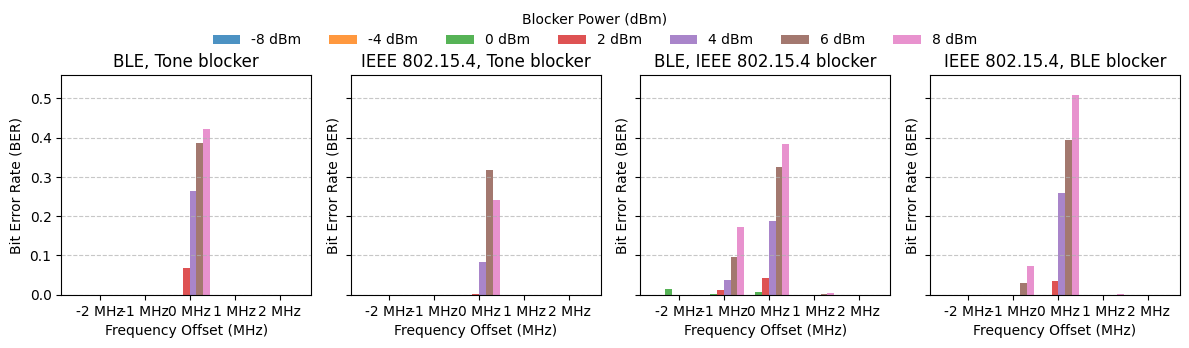

In [31]:
# Call the function
plot_grouped_ber_with_subplots(files_dict, saveas="BER_plot_all.pdf")


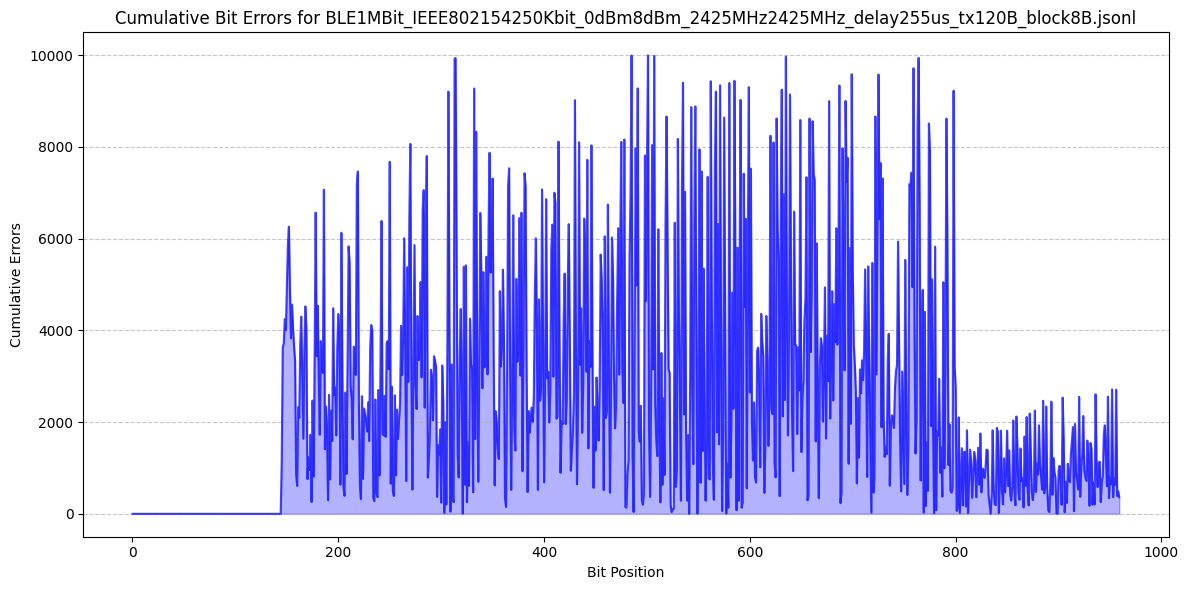

In [8]:
# Function to plot cumulative bit errors for a specific file
def plot_cumulative_bit_errors(file):
    cumulative_errors = file["bit_error_distribution_cumulative"]
    bit_positions = range(len(cumulative_errors))

    plt.figure(figsize=(12, 6))
    plt.plot(bit_positions, cumulative_errors, color="blue", alpha=0.7, label="Cumulative Errors")
    plt.fill_between(bit_positions, cumulative_errors, color="blue", alpha=0.3)  # Fill the area under the curve
    plt.title(f"Cumulative Bit Errors for {file['filename']}")
    plt.xlabel("Bit Position")
    plt.ylabel("Cumulative Errors")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# Example: Plot for the first file in a group
example_file = files_dict["BLE1MBit_IEEE802154250Kbit"][20]
plot_cumulative_bit_errors(example_file)


# Same protocol blocking

In [43]:
# Parse file names into dictionaries
files_dict_same = parse_data_to_dictionary("experiment_data/same_protocol_blocker")

# Add bitt error distribution, count and BER to each configuration (file)
add_bit_errors_to_files_dict(files_dict_same, "experiment_data/same_protocol_blocker")

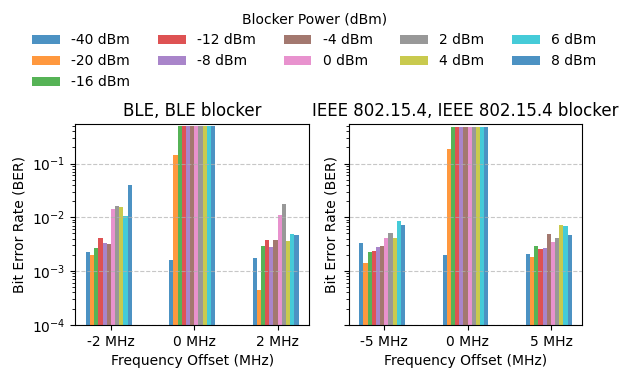

In [56]:
plot_grouped_ber_with_subplots(files_dict_same, 
                               bar_width=0.05, 
                               figsize=(6,3.8), 
                               log_scale=True, 
                               saveas="BER_plot_same.pdf",
                               max_legend_col=5,
                               legend_vskip=0.78)